#**ATLAS Autoencoders GSoC 2021**

In this notebook we will use some ATLAS data and train an autoencoder neural network to try and compress the "four-momentum" of the jet particles. Let's start.

In [ ]:
import pandas as pd
import re

###Looking into the dataset
First, we need to look into our dataset and solve the delimiter problem. Here we run through the dataset line after line and we split the lines by ',' or ';' then look for our jets in each line and add them to the list.

In [38]:
jets = []
with open('/content/monojet_Zp2000.0_DM_50.0_chan3.csv') as fobj:
    for line in fobj:
        tokens = re.split(',|;', line)
        for index, token in enumerate(tokens):
            if token == 'j':
              jet = []
              for elem in tokens[(index+1):(index+5)]:
                jet.append(float(elem))
              jets.append(jet)

In [39]:
df = pd.DataFrame(jets, columns=('e','pt','eta','phi'))

In [40]:
df.head()

,e,pt,eta,phi
0,258722.0,243675.0,0.328962,2.25014
1,520092.0,108590.0,-2.247300,-1.85679
2,383024.0,88405.6,2.145160,-1.95635
3,39507.6,35365.1,0.470460,-1.16445
4,225430.0,26878.2,-2.816080,-2.25938


First, We need to look into general information about our dataset and check if there are any missing values to think of a way to handle them.


In [46]:
df.describe()

,e,pt,eta,phi
count,22661.000000,22661.000000,22661.000000,22661.000000
mean,0.093624,0.105996,0.507326,0.498056
std,0.097121,0.128663,0.156509,0.288138
min,0.000000,0.000000,0.000000,0.000000
25%,0.021385,0.012256,0.406823,0.248106
50%,0.060748,0.048161,0.507493,0.498883
75%,0.137141,0.165593,0.608777,0.745767
max,1.000000,1.000000,1.000000,1.000000


In [47]:
df.isna().sum()/(len(df))*100

e      0.0
pt     0.0
eta    0.0
phi    0.0
dtype: float64

Now that we are sure that there are no missing values we can go to the next step.

We can see that the features have very diffrent value ranges so it is a must to normalize our data to get our features to a common scale.
For the normalization , I used sklearn library's MinMaxScaler.



In [41]:
from sklearn import preprocessing

def normalize(df):
  '''We normalize the given dataset's features 
  using the minmaxscaler of sklearn library'''

  x = df.values #returns a numpy array
  min_max_scaler = preprocessing.MinMaxScaler()
  x_scaled = min_max_scaler.fit_transform(x)
  return pd.DataFrame(x_scaled, columns=('e','pt','eta','phi'))

In [28]:
import matplotlib.pyplot as plt

def visualize(df):
  unit_list = ['[GeV]','[GeV]', '[rad]', '[rad]']
  variable_list = ['E',r'$p_T$', r'$\eta$', r'$\phi$']

  branches=["e","pt","eta","phi"]

  n_bins = 100

  for k in range(0,4):
      n_hist_data, bin_edges, _ = plt.hist(df[branches[k]], color='gray', label='Input', alpha=1, bins=n_bins)
      plt.xlabel(xlabel=variable_list[k] + ' ' + unit_list[k])
      plt.ylabel('# of events')
      plt.show()

After defining our visulization and normalization function let's visualize our data using the matplotlib library.

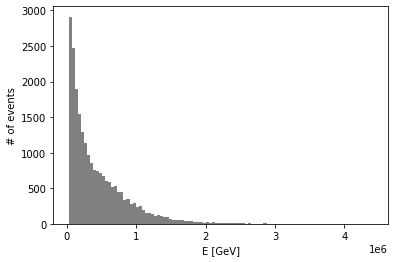

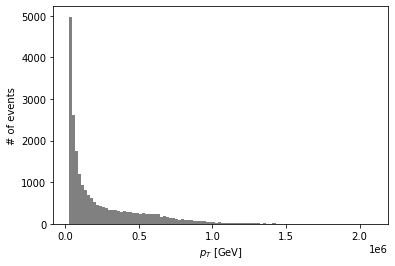

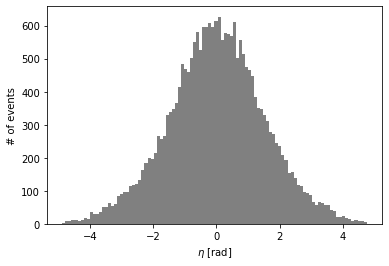

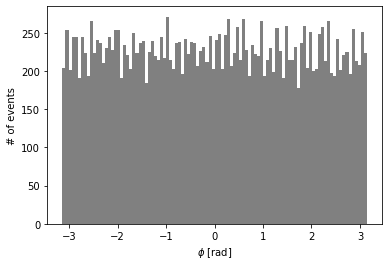

In [42]:
visualize(df)

In [43]:
df = normalize(df)

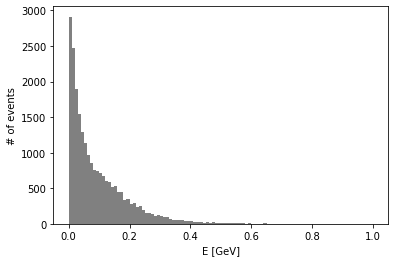

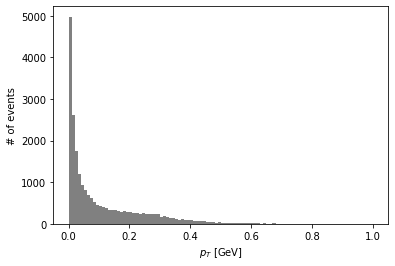

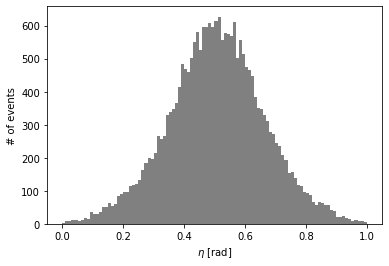

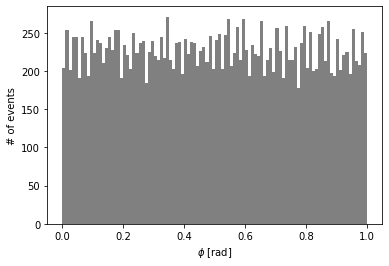

In [44]:
visualize(df)

Visualizing the data before and after the normalization shows us that the shape of the distribution is still the same so the normalization was successful.

##Setting up the network
###Preparing the data
Adding the two datasets as TensorDatasets to PyTorch (also loading all other classes we'll need later)

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import learner
from fastai.data import core



In [11]:
#Since we are creating an autoencoder, the input and output data is the same
ds = TensorDataset(torch.tensor(df.values, dtype=torch.float), torch.tensor(df.values, dtype=torch.float))

#We split our data into training set and test set
train_ds, test_ds = torch.utils.data.random_split(ds, [int(0.8 * len(ds)), len(ds) - int(0.8 * len(ds))])

We now set things up to load the data, and we use a batch size that was optimized by previous students...note also that this is fastai v2, migration thanks to Jessica Lastow.



In [13]:
bs = 256

# Converts the TensorDataset into a DataLoader object and
# combines into one DataLoaders object (a basic wrapper
# around several DataLoader objects). 
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=bs * 2)
dls = core.DataLoaders(train_dl, test_dl)

###Preparing the network

Here we have an example network. Details aren't too important, as long as they match what was already trained for us...in this case we have a LeakyReLU, tanh activation function, and a number of layers that goes from 4 to 200 to 20 to 3 (number of features in the hidden layer that we pick for testing compression) and then back all the way to 4.

In [14]:
class AE_3D_200_LeakyReLU(nn.Module):
    def __init__(self, n_features=4):
        super(AE_3D_200_LeakyReLU, self).__init__()
        self.en1 = nn.Linear(n_features, 200)
        self.en2 = nn.Linear(200, 200)
        self.en3 = nn.Linear(200, 20)
        self.en4 = nn.Linear(20, 3)
        self.de1 = nn.Linear(3, 20)
        self.de2 = nn.Linear(20, 200)
        self.de3 = nn.Linear(200, 200)
        self.de4 = nn.Linear(200, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'in-200-200-20-3-20-200-200-out'

#model = AE_3D_200_LeakyReLU().double()
model = AE_3D_200_LeakyReLU()
model.to('cpu')

AE_3D_200_LeakyReLU(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=200, bias=True)
  (en3): Linear(in_features=200, out_features=20, bias=True)
  (en4): Linear(in_features=20, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=20, bias=True)
  (de2): Linear(in_features=20, out_features=200, bias=True)
  (de3): Linear(in_features=200, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (tanh): Tanh()
)

We now have to pick a loss function - MSE loss is appropriate for a compression autoencoder since it reflects the [(input-output)/input] physical quantity that we want to minimize.

In [15]:
from fastai.metrics import mse

loss_func = nn.MSELoss()

#bn_wd = False  # Don't use weight decay for batchnorm layers
#true_wd = True  # weight decay will be used for all optimizers
wd = 1e-6

recorder = learner.Recorder()
learn = learner.Learner(dls, model=model, wd=wd, loss_func=loss_func, cbs=recorder)
#was: learn = basic_train.Learner(data=db, model=model, loss_func=loss_func, wd=wd, callback_fns=ActivationStats, bn_wd=bn_wd, true_wd=true_wd)

##Training a new network
Since we don't have a pretrained model like the example we need to create a brand new one.
First, we want to find the best learning rate. The learning rate is a hyper-paramater that sets how much the weights of the network will change each step with respect to the loss gradient.

Then we plot the loss versus the learning rates. We're interested in finding a good order of magnitude of learning rate, so we plot with a log scale.

A good value for the learning rates is then either:

1.  one tenth of the minimum before the divergence
2.  when the slope is the steepest






Learning rate with the minimum loss: 0.003981071710586548
Learning rate with the steepest gradient: 0.0003981071640737355


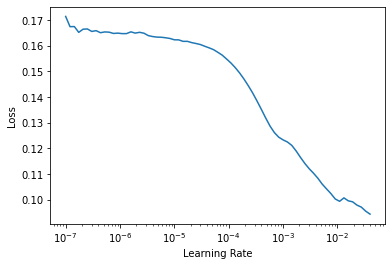

In [16]:
from fastai.callback import schedule

lr_min, lr_steep = learn.lr_find()

print('Learning rate with the minimum loss:', lr_min)
print('Learning rate with the steepest gradient:', lr_steep)

Now we go to the training part.
We can either chose lr_min or lr_steep as the learning rate.
Here, we're going to chose lr_min.

In [18]:
import time

start = time.perf_counter() # Starts timer
learn.fit_one_cycle(100,lr_min)
end = time.perf_counter() # Ends timer
delta_t = end - start
print('Training took', delta_t, 'seconds')

[0, 0.03723962604999542, 0.02252705581486225, '00:01']
[0, 0.03723962604999542, 0.02252705581486225, '00:01']
[1, 0.016821222379803658, 0.007860401645302773, '00:00']
[1, 0.016821222379803658, 0.007860401645302773, '00:00']
[2, 0.00810851901769638, 0.0028707743622362614, '00:00']
[2, 0.00810851901769638, 0.0028707743622362614, '00:00']
[3, 0.002854759804904461, 0.0009650276042521, '00:01']
[3, 0.002854759804904461, 0.0009650276042521, '00:01']
[4, 0.0014439139049500227, 0.0009078964940272272, '00:00']
[4, 0.0014439139049500227, 0.0009078964940272272, '00:00']
[5, 0.0010687552858144045, 0.0008608784410171211, '00:00']
[5, 0.0010687552858144045, 0.0008608784410171211, '00:00']
[6, 0.00098075857385993, 0.0008479944663122296, '00:00']
[6, 0.00098075857385993, 0.0008479944663122296, '00:00']
[7, 0.0009296968346461654, 0.0008120823185890913, '00:00']
[7, 0.0009296968346461654, 0.0008120823185890913, '00:00']
[8, 0.0007903929799795151, 0.0005950609338469803, '00:00']
[8, 0.0007903929799795151

Then we plot the loss as a function of batches and epochs to check if we reach a plateau.



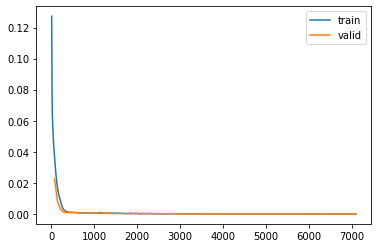

In [19]:
recorder.plot_loss()

Then we evaluate the MSE on this network - it should be of the order of 0.001 or less if all has gone well

In [20]:
learn.validate()


(#1) [1.03068691714725e-06]

since it's a lot smaller than the order of 0.001, then our training went well.
Now let's go to plotting.

###Plotting the outputs of the network

A function in case we want to un-normalize and get back to physical quantities...

In [33]:
def unnormalize(df,scaler):
  '''This function receives the dataset to 
  unnormalize and the scaler used to normalize it'''
  
  return pd.DataFrame(scaler.inverse_transform(df.to_numpy()),columns=('e','pt','eta','phi'))


Make the histograms from the dataset

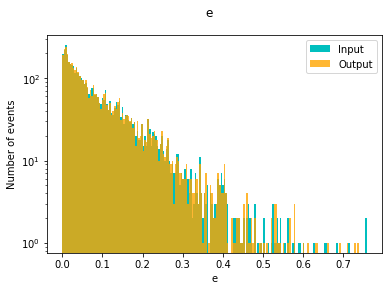

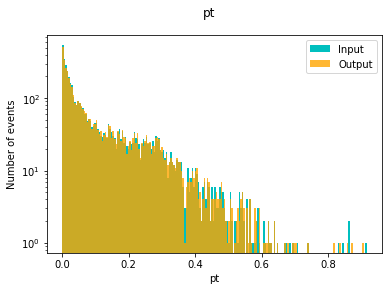

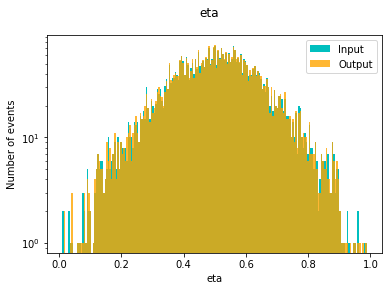

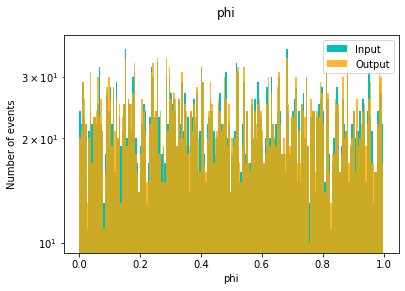

In [24]:
import numpy as np

colors = ['orange', 'c']

test_x, test_y = ds[test_ds.indices]

pred = model(test_x)

data = test_y.detach().numpy()   
pred = pred.detach().numpy()

data_df = pd.DataFrame(data, columns=df.columns)
pred_df = pd.DataFrame(pred, columns=df.columns)

unnormalized_data_df = unnormalize(data_df,min_max_scaler)
unnormalized_pred_df = unnormalize(pred_df,min_max_scaler)

alph = 0.8
n_bins = 200
for kk in np.arange(4):
    plt.figure()
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(df.columns[kk])
    plt.xlabel(df.columns[kk])
    plt.ylabel('Number of events')
    # ms.sciy()
    plt.yscale('log')
    plt.legend()

We can see that the compression and decompression process went fairly well by the matching of the input and the output in the histograms.

(array([ 2.,  9., 14., 46., 52., 31., 27.,  8.,  6.,  5.]),
 array([-0.31578947, -0.24849624, -0.18120301, -0.11390977, -0.04661654,
         0.02067669,  0.08796992,  0.15526316,  0.22255639,  0.28984962,
         0.35714286]),
 <a list of 10 Patch objects>)

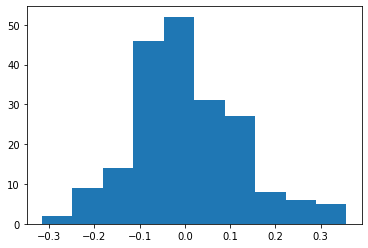

In [27]:
def getRatio(bin1,bin2):
    bins = []
    for b1,b2 in zip(bin1,bin2):
        if b1==0 and b2==0:
            bins.append(0.)
        elif b2==0:
            bins.append(None)
        else:
            bins.append((float(b2)-float(b1))/b1)
    return bins   

rat = getRatio(n_hist_data,n_hist_pred)
plt.hist(rat)

This plot shows us the distribution of the error between our original data and the predicted data . It is not perfect but since it is centered around 0, we can say that it was a pretty good job.